# 1.Import Library

In [132]:
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
import time

import matplotlib.pyplot as plt
import re
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.ensemble import VotingClassifier
import gc
from sklearn.tree import DecisionTreeClassifier
import xgboost
from sklearn.neural_network import MLPClassifier


# 2.Import Data

In [150]:
train= pd.read_csv("order_products__train.csv")
priors = pd.read_csv("order_products__prior.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
sample_submission = pd.read_csv( "sample_submission.csv")

In [70]:
train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [71]:
priors.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [72]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [73]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [74]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [75]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


# 3.EDA

In [76]:
# Combine them to one table
order_products_total = pd.concat([priors, train])
order_products_total = order_products_total.merge(products, on='product_id', how='left')
order_products_total = order_products_total.merge(aisles, on='aisle_id', how='left')
order_products_total = order_products_total.merge(departments, on='department_id', how='left')


In [87]:
order_products_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33819106 entries, 0 to 33819105
Data columns (total 9 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   order_id           int64 
 1   product_id         int64 
 2   add_to_cart_order  int64 
 3   reordered          int64 
 4   product_name       object
 5   aisle_id           int64 
 6   department_id      int64 
 7   aisle              object
 8   department         object
dtypes: int64(6), object(3)
memory usage: 2.5+ GB


## Department Sales

In [78]:
departments_sales = order_products_total['department'].value_counts().reset_index()
departments_sales.columns = ['department', 'sales']


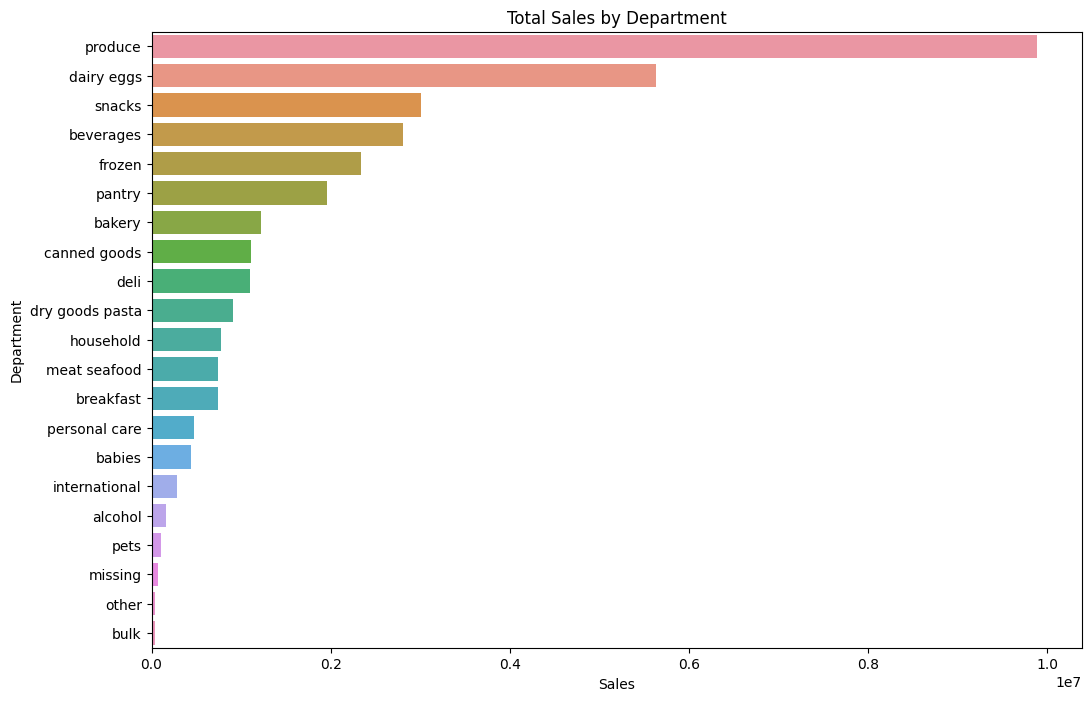

In [79]:
plt.figure(figsize=(12, 8))
sns.barplot(x='sales', y='department', data=departments_sales)
plt.xlabel('Sales')
plt.ylabel('Department')
plt.title('Total Sales by Department')
plt.show()

## Distribution of Orders by Hour of Day

In [80]:
order_hour_dist = orders['order_hour_of_day'].value_counts().reset_index()
order_hour_dist.columns = ['hour', 'orders']


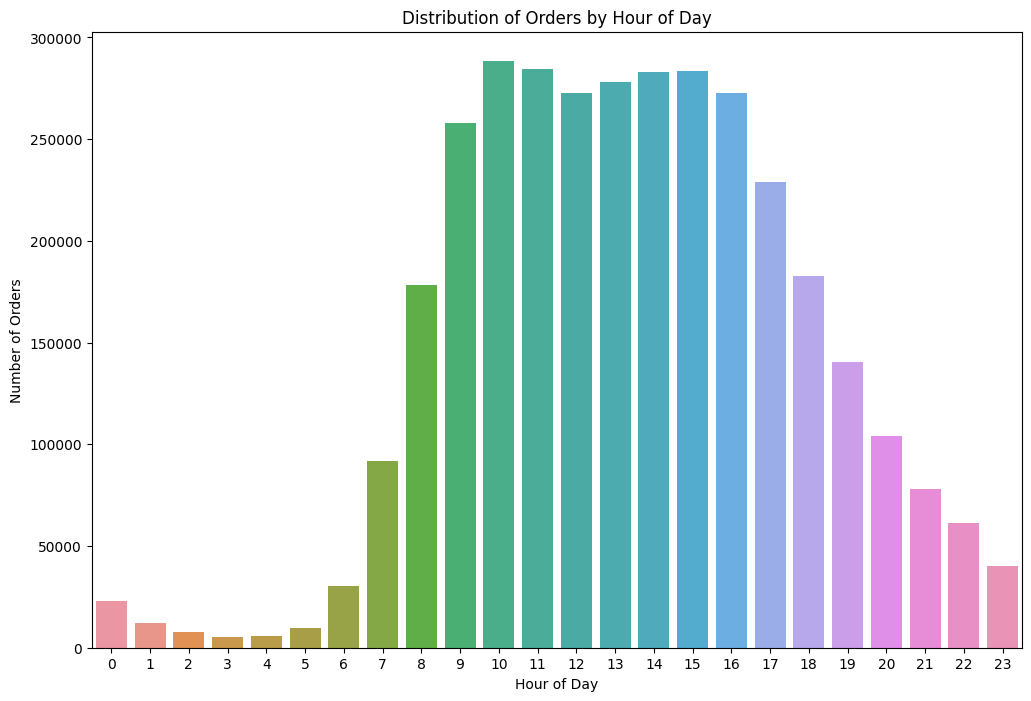

In [81]:
plt.figure(figsize=(12, 8))
sns.barplot(x='hour', y='orders', data=order_hour_dist)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Orders')
plt.title('Distribution of Orders by Hour of Day')
plt.show()


## Top 10 reorder item

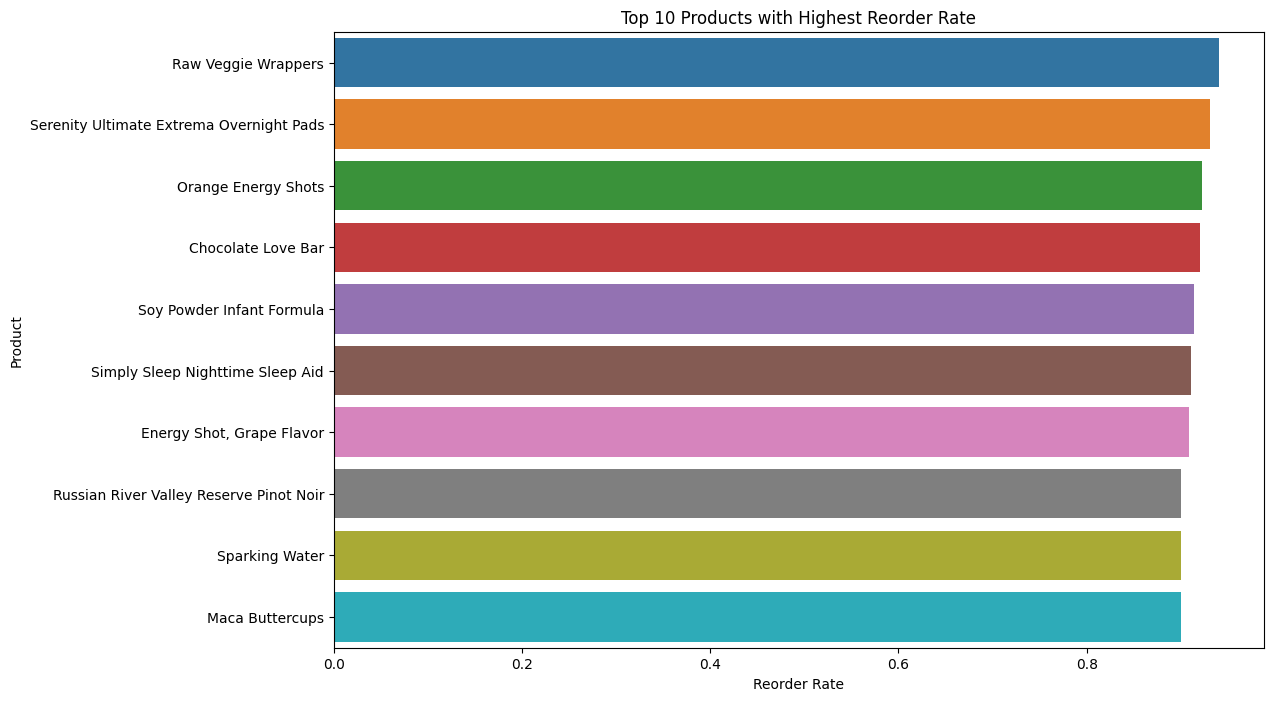

In [53]:
reorder_rate = order_products_total.groupby('product_id')['reordered'].mean().reset_index()
reorder_rate.columns = ['product_id', 'reorder_rate']
top10_reorder_rate = reorder_rate.sort_values(by='reorder_rate', ascending=False).head(10)
top10_reorder_rate = top10_reorder_rate.merge(products, on='product_id', how='left')

plt.figure(figsize=(12, 8))
sns.barplot(x='reorder_rate', y='product_name', data=top10_reorder_rate)
plt.xlabel('Reorder Rate')
plt.ylabel('Product')
plt.title('Top 10 Products with Highest Reorder Rate')
plt.show()


## Average Add to Cart Order by Department

In [54]:
department_add_order = order_products_total.groupby('department')['add_to_cart_order'].mean().reset_index()
department_add_order.columns = ['department', 'avg_add_to_cart_order']


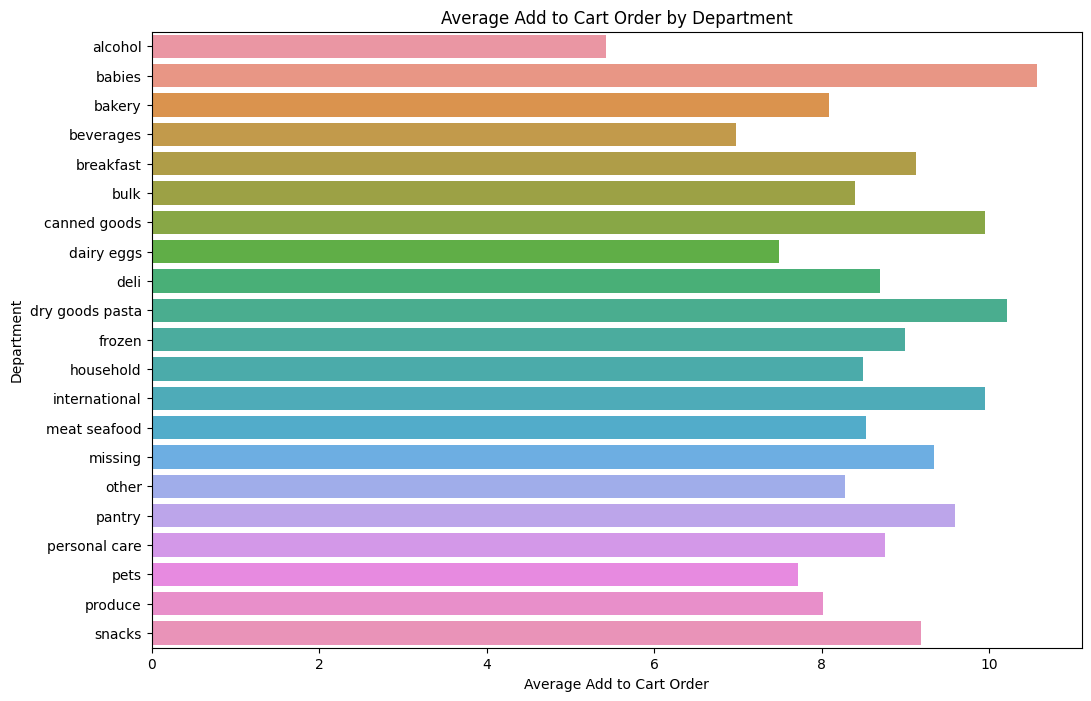

In [55]:
plt.figure(figsize=(12, 8))
sns.barplot(x='avg_add_to_cart_order', y='department', data=department_add_order)
plt.xlabel('Average Add to Cart Order')
plt.ylabel('Department')
plt.title('Average Add to Cart Order by Department')
plt.show()


## Distribution of User Average Days Since Prior Order

In [56]:
user_days_since_prior_order = orders.groupby('user_id')['days_since_prior_order'].mean().reset_index()
user_days_since_prior_order.columns = ['user_id', 'avg_days_since_prior_order']


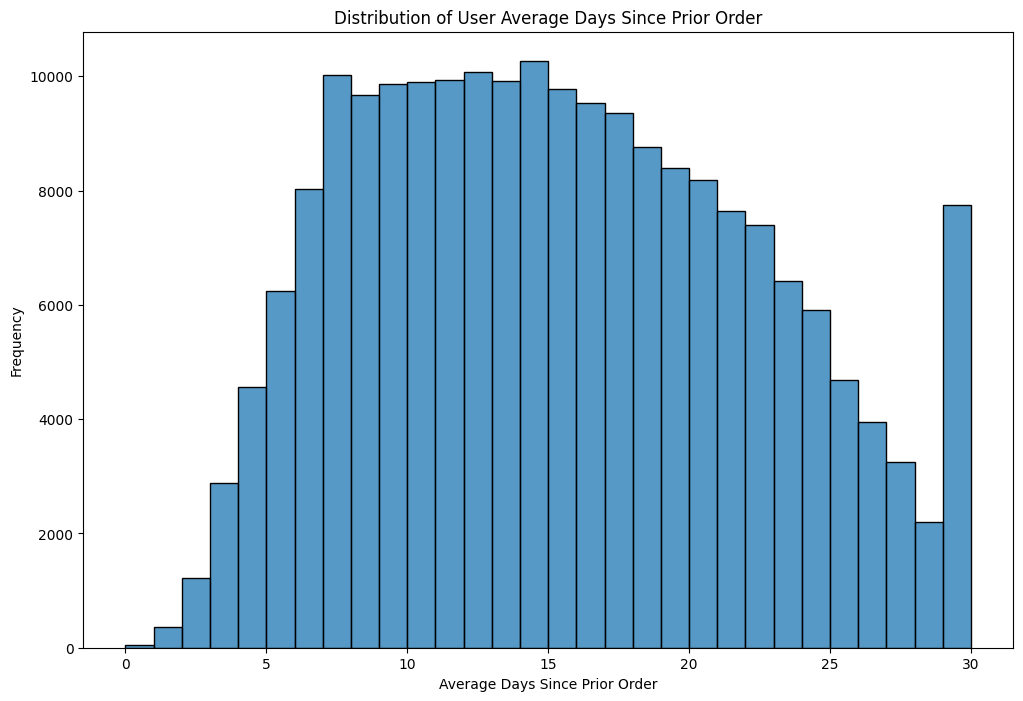

In [57]:
plt.figure(figsize=(12, 8))
sns.histplot(user_days_since_prior_order['avg_days_since_prior_order'], kde=False, bins=30)
plt.xlabel('Average Days Since Prior Order')
plt.ylabel('Frequency')
plt.title('Distribution of User Average Days Since Prior Order')
plt.show()


## Reorder Rate by Day of Week

In [61]:
order_dow_reorder_rate = order_products_total.merge(orders, on='order_id', how='left').groupby('order_dow')['reordered'].mean().reset_index()
order_dow_reorder_rate.columns = ['day_of_week', 'reorder_rate']


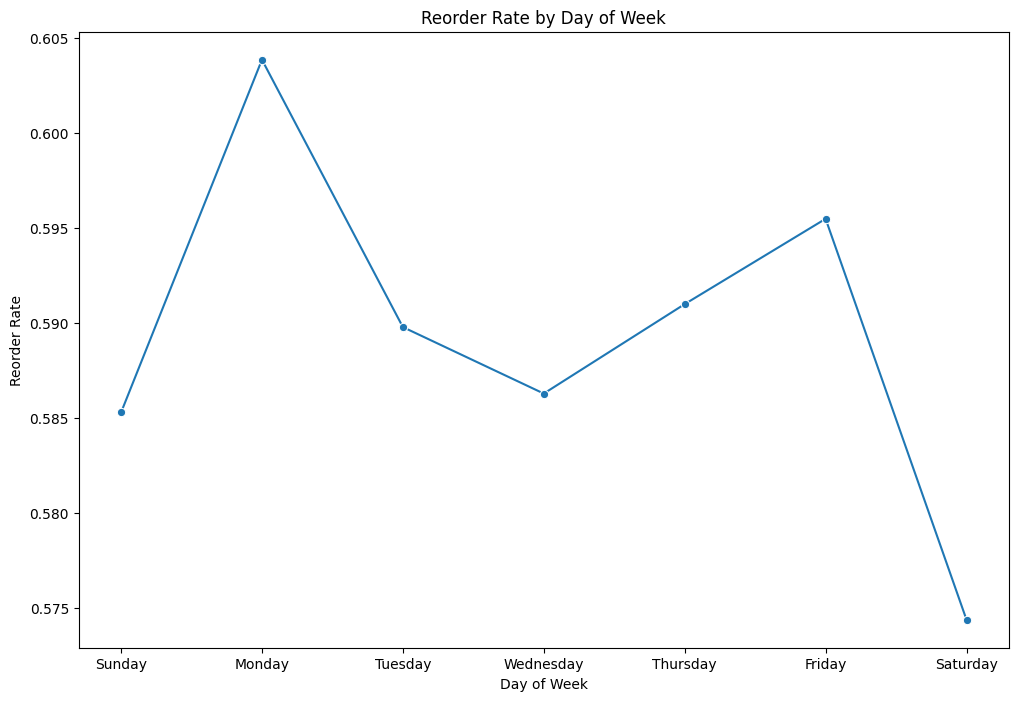

In [62]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='day_of_week', y='reorder_rate', data=order_dow_reorder_rate, marker='o')
plt.xlabel('Day of Week')
plt.ylabel('Reorder Rate')
plt.title('Reorder Rate by Day of Week')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.show()


## Reorder Rate by Department

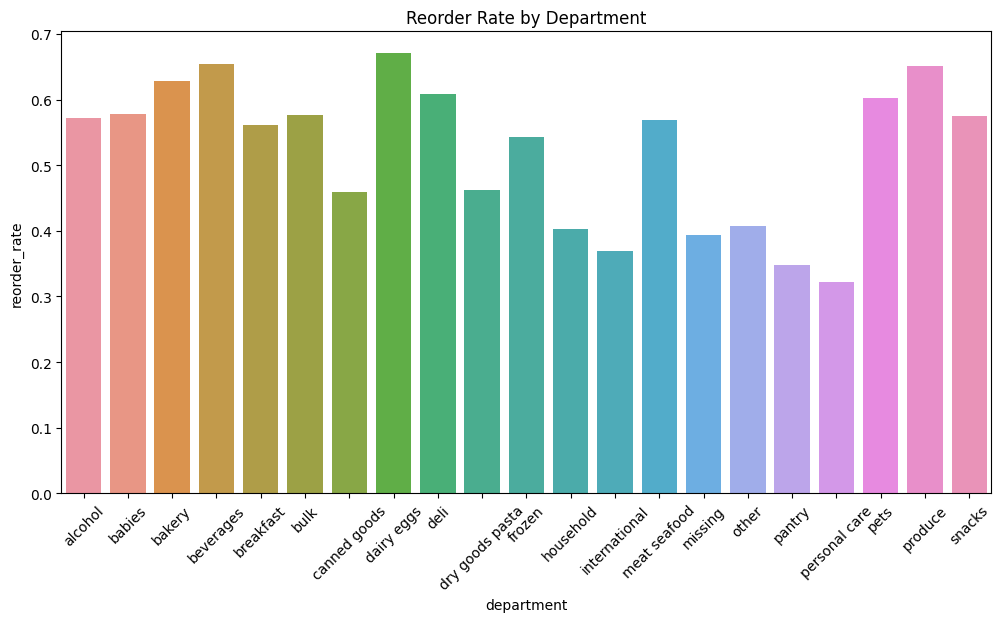

In [90]:
grouped_dept = order_products_total.groupby('department')['reordered'].agg(['count', 'sum']).reset_index()
grouped_dept['reorder_rate'] = grouped_dept['sum'] / grouped_dept['count']

plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_dept, x='department', y='reorder_rate')
plt.xticks(rotation=45)
plt.title('Reorder Rate by Department')
plt.show()


## Top 20 Aisles by Reorder Rate

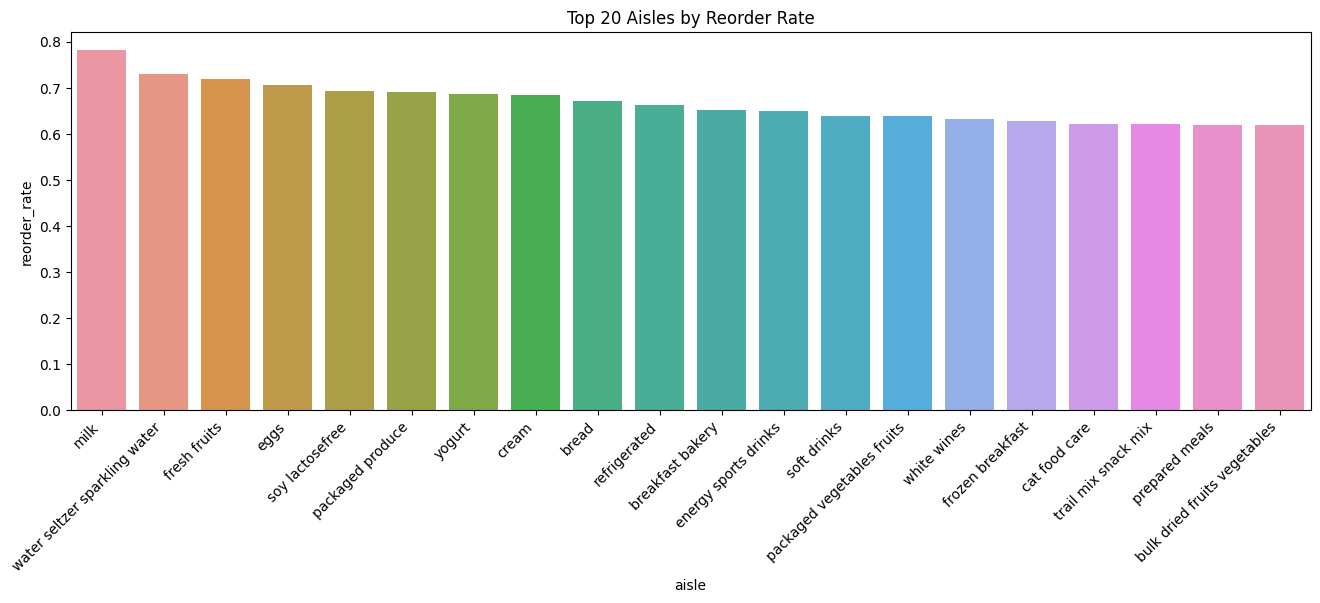

In [115]:
grouped_aisle = order_products_total.groupby('aisle')['reordered'].agg(['count', 'sum']).reset_index()
grouped_aisle['reorder_rate'] = grouped_aisle['sum'] / grouped_aisle['count']
grouped_aisle = grouped_aisle.sort_values('reorder_rate', ascending=False).iloc[:20]

plt.figure(figsize=(16, 6))
sns.barplot(data=grouped_aisle, x='aisle', y='reorder_rate')
plt.xticks(rotation=45, ha='right')
plt.subplots_adjust(bottom=0.25)
plt.title('Top 20 Aisles by Reorder Rate')
plt.show()



# 4.Feature Engineering

## Define Function

In [3]:



# Define a context manager class 'tick_tock' to measure the time taken by a block of code.
class tick_tock:
    def __init__(self, process_name, verbose=1):
        self.process_name = process_name
        self.verbose = verbose

    # When entering the context, print the process name and record the start time.
    def __enter__(self):
        if self.verbose:
            print(self.process_name + " begin ......")
            self.begin_time = time.time()

    # When exiting the context, print the process name, and calculate and print the time taken.
    def __exit__(self, _type, _value, _traceback):
        if self.verbose:
            end_time = time.time()
            print(self.process_name + " end ......")
            print('time lapsing {0} s \n'.format(end_time - self.begin_time))

# Define a function to add aggregated features to a DataFrame using 1-to-n groupby operations.
def ka_add_groupby_features_1_vs_n(df, group_columns_list, agg_dict, only_new_feature=True):
    # Use the tick_tock context manager to measure the time taken by this function.
    with tick_tock("add stats features"):
        if not isinstance(group_columns_list, list):
            raise TypeError("group_columns_list should be a list")

        df_new = df.copy()
        grouped = df_new.groupby(group_columns_list)

        # Perform the aggregation using the given dictionary.
        the_stats = grouped.agg(agg_dict)
        the_stats.columns = the_stats.columns.droplevel(0)
        the_stats.reset_index(inplace=True)
        if only_new_feature:
            df_new = the_stats
        else:
            df_new = pd.merge(left=df_new, right=the_stats, on=group_columns_list, how='left')

    return df_new

# Define a function to add aggregated features to a DataFrame using n-to-1 groupby operations.
def ka_add_groupby_features_n_vs_1(df, group_columns_list, target_columns_list, methods_list, keep_only_stats=True, verbose=1):
    # Use the tick_tock context manager to measure the time taken by this function.
    with tick_tock("add stats features", verbose):
        dicts = {"group_columns_list": group_columns_list , "target_columns_list": target_columns_list, "methods_list" :methods_list}

        for k, v in dicts.items():
            if not isinstance(v, list):
                raise TypeError(f"{k} should be a list")

        grouped_name = ''.join(group_columns_list)
        target_name = ''.join(target_columns_list)
        combine_name = [[grouped_name] + [method_name] + [target_name] for method_name in methods_list]

        df_new = df.copy()
        grouped = df_new.groupby(group_columns_list)

        # Perform the aggregation using the given methods.
        the_stats = grouped[target_name].agg(methods_list).reset_index()
        the_stats.columns = [grouped_name] + \
                            [f'_{grouped_name}_{method_name}_by_{target_name}' for (grouped_name, method_name, target_name) in combine_name]
        if keep_only_stats:
            return the_stats
        else:
            df_new = pd.merge(left=df_new, right=the_stats, on=group



## Item part

In [4]:
# add order information to priors set
priors_orders_detail = orders.merge(right=priors, how='inner', on='order_id')

# create new variables
# _user_buy_product_times: the time user by this item
priors_orders_detail['_user_buy_product_times'] = priors_orders_detail.groupby(['user_id', 'product_id']).cumcount() + 1

# _prod_tot_cnts: total number that item been sold
# _reorder_tot_cnts_of_this_prod: reorder number of this item
# _prod_order_once: the number of times that item only buy 1 
# _prod_order_more_than_once: the number of times that item buy more that once
agg_dict = {'order_id': [('_total_orders', 'count')],
            'add_to_cart_order': [('_sum_add_to_cart_order', 'sum')],
            'reordered': [('_reorder_total_cnt', 'sum')],
            '_user_buy_product_times': [('_prod_buy_first_time_total_cnt', lambda x: sum(x == 1)),
                                         ('_prod_buy_second_time_total_cnt', lambda x: sum(x == 2))]}

prd = ka_add_groupby_features_1_vs_n(priors_orders_detail, ['product_id'], agg_dict)

# _prod_reorder_prob: 
# _prod_reorder_ratio: 
prd['_prod_reorder_prob'] = prd['_prod_buy_second_time_total_cnt'] / prd['_prod_buy_first_time_total_cnt']
prd['_prod_reorder_ratio'] = prd['_reorder_total_cnt'] / prd['_total_orders']
prd['_prod_reorder_times'] = 1 + prd['_reorder_total_cnt'] / prd['_prod_buy_first_time_total_cnt']


add stats features begin ......
add stats features end ......
time lapsing 24.860395431518555 s 



In [5]:
prd.head()


,product_id,_total_orders,_sum_add_to_cart_order,_reorder_total_cnt,_prod_buy_first_time_total_cnt,_prod_buy_second_time_total_cnt,_prod_reorder_prob,_prod_reorder_ratio,_prod_reorder_times
0,1,1852,10745,1136,716,276,0.385475,0.613391,2.586592
1,2,90,890,12,78,8,0.102564,0.133333,1.153846
2,3,277,1777,203,74,36,0.486486,0.732852,3.743243
3,4,329,3128,147,182,64,0.351648,0.446809,1.807692
4,5,15,97,9,6,4,0.666667,0.600000,2.500000


## User Part

In [7]:
# _user_total_orders: 
# _user_sum_days_since_prior_order: 
# _user_mean_days_since_prior_order: 
agg_dict_2 = {'order_number': [('_user_total_orders', 'max')],
              'days_since_prior_order': [('_user_sum_days_since_prior_order', 'sum'),
                                          ('_user_mean_days_since_prior_order', 'mean')]}

users = ka_add_groupby_features_1_vs_n(orders[orders.eval_set == 'prior'], ['user_id'], agg_dict_2)

# _user_reorder_ratio: total number of reorder/total number of orders of first order
# _user_total_products: 
# _user_distinct_products: 
agg_dict_3 = {'reordered': [('_user_reorder_ratio',
                             lambda x: sum(priors_orders_detail.loc[x.index, 'reordered'] == 1) /
                                       sum(priors_orders_detail.loc[x.index, 'order_number'] > 1))],
              'product_id': [('_user_total_products', 'count'),
                             ('_user_distinct_products', lambda x: x.nunique())]}

us = ka_add_groupby_features_1_vs_n(priors_orders_detail, ['user_id'], agg_dict_3)
users = users.merge(us, how='inner')

# average number of item in each orders
users['_user_average_basket'] = users['_user_total_products'] / users['_user_total_orders']

us = orders[orders.eval_set != "prior"][['user_id', 'order_id', 'eval_set', 'days_since_prior_order']]
us.rename(columns={'days_since_prior_order': 'time_since_last_order'}, inplace=True)

users = users.merge(us, how='inner')


add stats features begin ......
add stats features end ......
time lapsing 0.19585514068603516 s 

add stats features begin ......
add stats features end ......
time lapsing 162.4721176624298 s 



In [8]:
users.head()

,user_id,_user_total_orders,_user_sum_days_since_prior_order,_user_mean_days_since_prior_order,_user_reorder_ratio,_user_total_products,_user_distinct_products,_user_average_basket,order_id,eval_set,time_since_last_order
0,1,10,176.0,19.555556,0.759259,59,18,5.900000,1187899,train,14.0
1,2,14,198.0,15.230769,0.510989,195,102,13.928571,1492625,train,30.0
2,3,12,133.0,12.090909,0.705128,88,33,7.333333,2774568,test,11.0
3,4,5,55.0,13.750000,0.071429,18,17,3.600000,329954,test,30.0
4,5,4,40.0,13.333333,0.538462,37,23,9.250000,2196797,train,6.0


## General Part

In [11]:
# _up_order_count: number of times user buy this item
# _up_first_order_number: order number of user that first time buy this item
# _up_last_order_number: order number of user that last time buy this item
# _up_average_cart_position: 
agg_dict_4 = {'order_number': [('_up_order_count', 'count'),
                               ('_up_first_order_number', 'min'),
                               ('_up_last_order_number', 'max')],
              'add_to_cart_order': [('_up_average_cart_position', 'mean')]}

data = ka_add_groupby_features_1_vs_n(df=priors_orders_detail,
                                      group_columns_list=['user_id', 'product_id'],
                                      agg_dict=agg_dict_4)

data = data.merge(prd, how='inner', on='product_id').merge(users, how='inner', on='user_id')
# _up_order_rate :number of times buy this item/ total order number
# _up_order_since_last_order   
# _up_order_rate_since_first_order : number of purchase of this item/ the number of orders between first time buy this item and last time buy this item 该
data['_up_order_rate'] = data['_up_order_count'] / data['_user_total_orders']
data['_up_order_since_last_order'] = data['_user_total_orders'] - data['_up_last_order_number']
data['_up_order_rate_since_first_order'] = data['_up_order_count'] / (data['_user_total_orders'] - data['_up_first_order_number'] + 1)

# add user_id to train set
train = train.merge(right=orders[['order_id', 'user_id']], how='left', on='order_id')
data = data.merge(train[['user_id', 'product_id', 'reordered']], on=['user_id', 'product_id'], how='left')

# release Memory
del priors_orders_detail, orders
gc.collect()
data.head()


add stats features begin ......
add stats features end ......
time lapsing 13.279645919799805 s 



,user_id,product_id,_up_order_count,_up_first_order_number,_up_last_order_number,_up_average_cart_position,_total_orders,_sum_add_to_cart_order,_reorder_total_cnt,_prod_buy_first_time_total_cnt,...,_user_total_products,_user_distinct_products,_user_average_basket,order_id,eval_set,time_since_last_order,_up_order_rate,_up_order_since_last_order,_up_order_rate_since_first_order,reordered
0,1,196,10,1,10,1.400000,35791,133206,27791,8000,...,59,18,5.9,1187899,train,14.0,1.0,0,1.000000,1.0
1,1,10258,9,2,10,3.333333,1946,8324,1389,557,...,59,18,5.9,1187899,train,14.0,0.9,0,1.000000,1.0
2,1,10326,1,5,5,5.000000,5526,23160,3603,1923,...,59,18,5.9,1187899,train,14.0,0.1,5,0.166667,NaN
3,1,12427,10,1,10,3.300000,6476,30826,4797,1679,...,59,18,5.9,1187899,train,14.0,1.0,0,1.000000,NaN
4,1,13032,3,2,10,6.333333,3751,21091,2465,1286,...,59,18,5.9,1187899,train,14.0,0.3,0,0.333333,1.0


# 5.Model

## XGB

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


[0]	train-logloss:0.62558
[10]	train-logloss:0.33500
[20]	train-logloss:0.26798
[30]	train-logloss:0.25055
[40]	train-logloss:0.24582
[50]	train-logloss:0.24416
[60]	train-logloss:0.24345
[70]	train-logloss:0.24288
[79]	train-logloss:0.24252


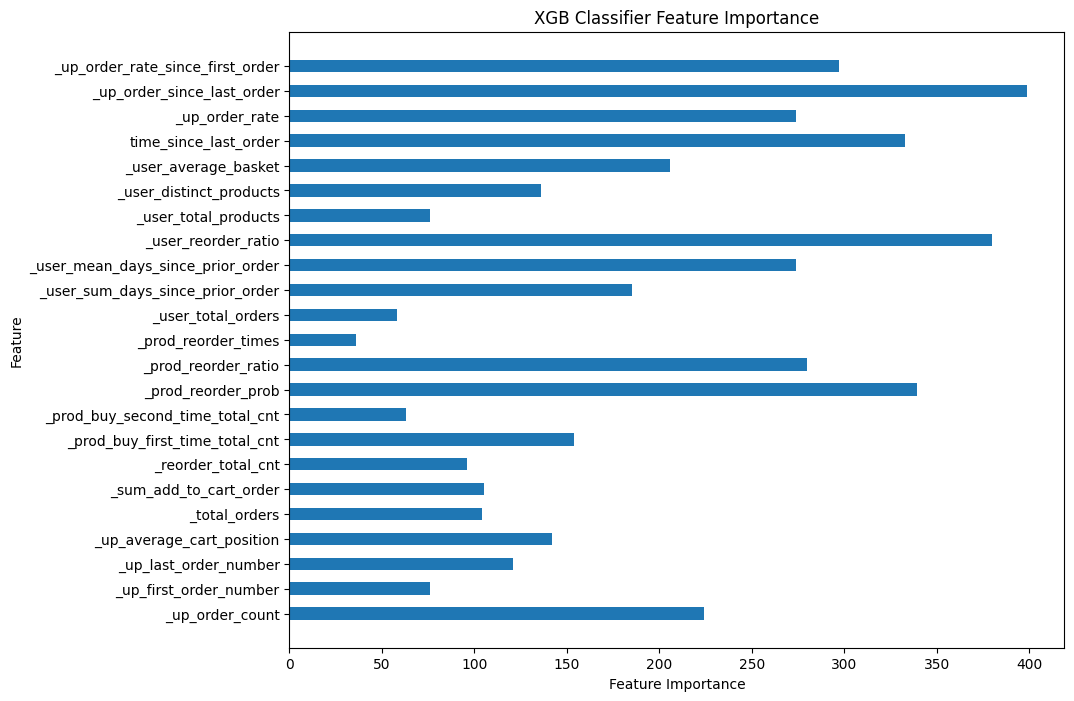

In [139]:
#train test split
train = data.loc[data.eval_set == "train", :]
train.drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis=1, inplace=True)
train.loc[:, 'reordered'] = train.reordered.fillna(0)

X_test = data.loc[data.eval_set == "test", :]

# subsample save time
X_train, X_val, y_train, y_val = train_test_split(train.drop('reordered', axis=1), train.reordered,
                                                    test_size=0.9, random_state=42)
d_train = xgboost.DMatrix(X_train, y_train)
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
    ,"n_jobs"           : 16
}

watchlist = [(d_train, "train")]
bst = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=80, evals=watchlist, verbose_eval=10)

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(X_train.columns, bst.get_fscore().values(), height=0.5)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('XGB Classifier Feature Importance')
plt.show()


In [140]:
# Create a DMatrix from the test data, dropping unnecessary columns
d_test = xgboost.DMatrix(X_test.drop(['eval_set', 'user_id', 'order_id', 'reordered', 'product_id'], axis=1))

# Use the XGBoost model (bst) to predict the reordered items and store the results in the 'reordered' column
X_test.loc[:, 'reordered'] = (bst.predict(d_test) > 0.21).astype(int)

# Convert 'product_id' to a string type
X_test.loc[:, 'product_id'] = X_test.product_id.astype(str)

# Use the function 'ka_add_groupby_features_n_vs_1' to create a submission DataFrame with reordered products for each order
submit = ka_add_groupby_features_n_vs_1(X_test[X_test.reordered == 1], 
                                        group_columns_list=['order_id'],
                                        target_columns_list=['product_id'],
                                        methods_list=[lambda x: ' '.join(set(x))], keep_only_stats=True)

# Set column names to match the sample submission
submit.columns = sample_submission.columns.tolist()

# Merge the submission DataFrame with the sample submission, and fill missing values with 'None'
submit_final_xgb = sample_submission[['order_id']].merge(submit, how='left').fillna('None')

submit_final_xgb

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


add stats features begin ......
add stats features end ......
time lapsing 0.7752046585083008 s 



,order_id,products
0,17,13107 21463
1,34,21137 39180 47792 43504 13176 47766 44663 1608...
2,137,38689 5134 41787 23794 2326 25890 24852
3,182,32109 41149 33000 47672 39275 9337 11520 47209...
4,257,21137 27966 28476 49235 29837 37646 27104 4605...
...,...,...
74995,3420740,19660 13176 16291 49005 8174 35951 39146 46252
74996,3420877,21137 27966 43122 10768 13176 49111 12238 8277...
74997,3420888,20542 43961 44632 22935 35951 46906 28985 4776...
74998,3420989,5134 46676 47229 21616 42450 35004 43210 47766...


In [141]:
d_val = xgboost.DMatrix(X_val, y_val)
y_val_pred = (bst.predict(d_val) > 0.21).astype(int)
f1 = f1_score(y_val, y_val_pred)
accuracy = accuracy_score(y_val, y_val_pred)

print("F1 Score: {:.4f}".format(f1))
print("Accuracy Score: {:.4f}".format(accuracy))


F1 Score: 0.4419
Accuracy Score: 0.8747


## DT

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

add stats features begin ......
add stats features end ......
time lapsing 0.8892025947570801 s 



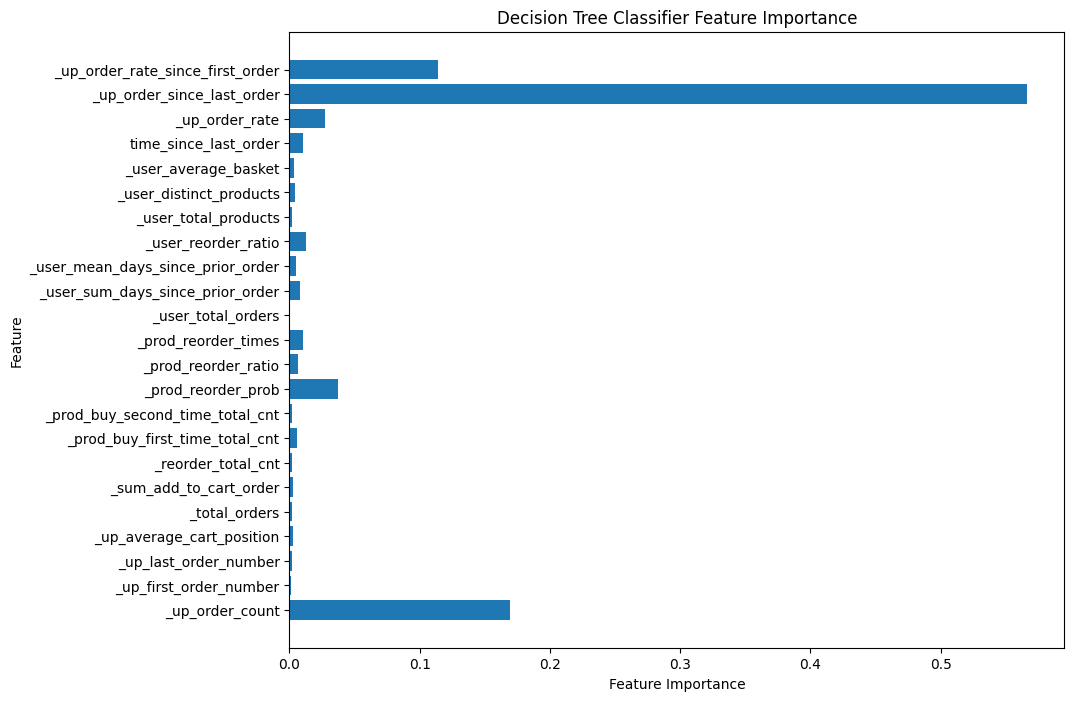

In [142]:

#train test split
train = data.loc[data.eval_set == "train", :]
train.drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis=1, inplace=True)
train.loc[:, 'reordered'] = train.reordered.fillna(0)

X_test = data.loc[data.eval_set == "test", :]

# subsample save time
X_train, X_val, y_train, y_val = train_test_split(train.drop('reordered', axis=1), train.reordered,
                                                    test_size=0.9, random_state=42)

# Train a Decision Tree classifier with specified parameters
dt = DecisionTreeClassifier(max_depth=10, min_samples_split=10, min_samples_leaf=10,class_weight='balanced')
dt.fit(X_train, y_train)

# Create a DataFrame to store 'order_id' and 'product_id' for test data
test_product_order = X_test[['order_id', 'product_id']]

# Drop unnecessary columns from the test data
X_test.drop(['eval_set', 'user_id', 'order_id', 'reordered', 'product_id'], axis=1, inplace=True)

# Use the Decision Tree classifier to predict reordered items and store the results in the 'reordered' column
X_test.loc[:, 'reordered'] = dt.predict(X_test)

# Update the 'reordered' column in the 'test_product_order' DataFrame
test_product_order.loc[:, 'reordered'] = X_test['reordered']

# Convert 'product_id' to a string type
test_product_order.loc[:, 'product_id'] = test_product_order.product_id.astype(str)

# Use the function 'ka_add_groupby_features_n_vs_1' to create a submission DataFrame with reordered products for each order
submit = ka_add_groupby_features_n_vs_1(test_product_order[test_product_order.reordered == 1], 
                                        group_columns_list=['order_id'],
                                        target_columns_list=['product_id'],
                                        methods_list=[lambda x: ' '.join(set(x))], keep_only_stats=True)

# Set column names to match the sample submission
submit.columns = sample_submission.columns.tolist()

# Merge the submission DataFrame with the sample submission, and fill missing values with 'None'
submit_final_dt = sample_submission[['order_id']].merge(submit, how='left').fillna('None')

# Calculate feature importances and print them along with the corresponding feature names
feature_importances = dt.feature_importances_
feature_names = X_train.columns

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(X_train.columns, dt.feature_importances_)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Decision Tree Classifier Feature Importance')
plt.show()


In [143]:
submit_final_dt 

,order_id,products
0,17,31964 13107 21903 39275 39928 21463 38777
1,34,21137 7948 13176 30353 49191 2596 39180 47792 ...
2,137,38689 24235 43352 29594 23794 25890 34126 5134...
3,182,32109 28800 22935 15252 47672 13629 40377 3927...
4,257,21137 38693 24838 30233 24964 27966 29837 2203...
...,...,...
74995,3420740,19660 11777 38772 46252 5785 16291 39928 10017...
74996,3420877,21137 11005 5449 6567 5918 7781 13176 12238 26...
74997,3420888,31506 22935 28985 42701 24964 30450 42123 4396...
74998,3420989,45866 7781 42450 28985 30406 27521 5134 21616 ...


In [144]:
y_val_pred = dt.predict(X_val)
f1 = f1_score(y_val, y_val_pred)
accuracy = accuracy_score(y_val, y_val_pred)

print("F1 Score: {:.4f}".format(f1))
print("Accuracy Score: {:.4f}".format(accuracy))


F1 Score: 0.3647
Accuracy Score: 0.7481


## LR

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


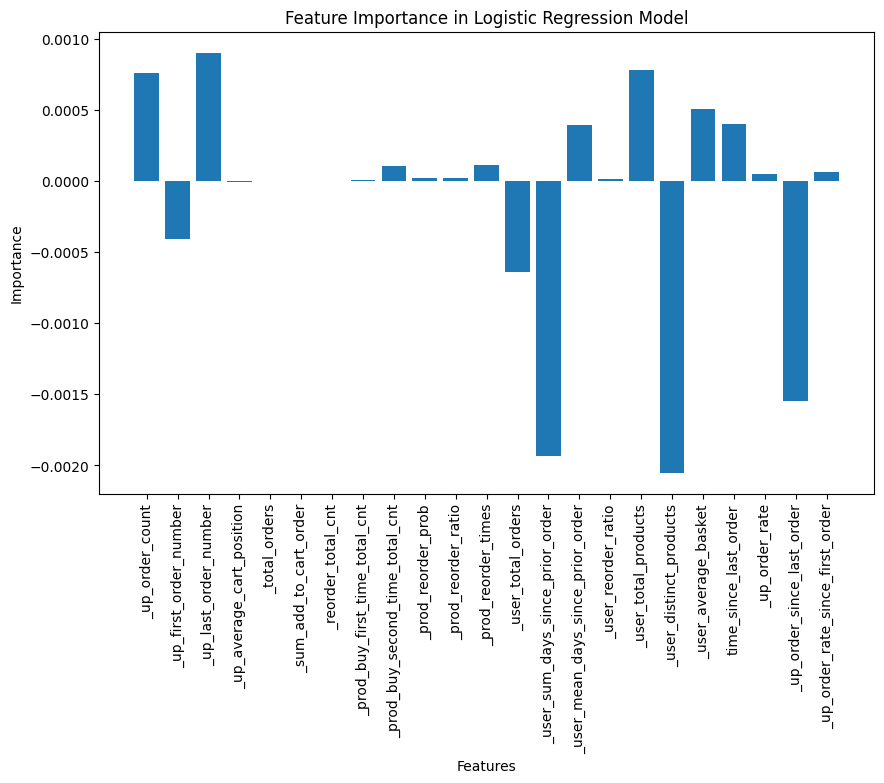

In [145]:
#train test split
train = data.loc[data.eval_set == "train", :]
train.drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis=1, inplace=True)
train.loc[:, 'reordered'] = train.reordered.fillna(0)

X_test = data.loc[data.eval_set == "test", :]

# subsample save time
X_train, X_val, y_train, y_val = train_test_split(train.drop('reordered', axis=1), train.reordered,
                                                    test_size=0.9, random_state=42)
# Import the necessary library
from sklearn.linear_model import LogisticRegression

# Initialize a Logistic Regression model with specified parameters
lr_model = LogisticRegression(n_jobs=16, random_state=42,class_weight='balanced')

# Fit the model using the training data
lr_model.fit(X_train, y_train)

# Predict the target variable on the validation data
y_val_pred = lr_model.predict(X_val)

# Get the feature importances (coefficients) from the Logistic Regression model
feature_importances = lr_model.coef_[0]

# Create a bar chart to visualize the feature importances
plt.figure(figsize=(10, 6))
plt.bar(X_train.columns, feature_importances)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance in Logistic Regression Model")
plt.show()



In [146]:
# Make predictions on the test data
X_test.loc[:, 'reordered'] = lr_model.predict(X_test.drop(['eval_set', 'user_id', 'order_id', 'reordered', 'product_id'], axis=1))

# Keep the same post-processing steps as before
X_test.loc[:, 'product_id'] = X_test.product_id.astype(str)

submit = ka_add_groupby_features_n_vs_1(X_test[X_test.reordered == 1], 
                                        group_columns_list=['order_id'],
                                        target_columns_list=['product_id'],
                                        methods_list=[lambda x: ' '.join(set(x))], keep_only_stats=True)
submit.columns = sample_submission.columns.tolist()

submit_final_lr = sample_submission[['order_id']].merge(submit, how='left').fillna('None')

submit_final_lr

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


add stats features begin ......
add stats features end ......
time lapsing 0.7443785667419434 s 



,order_id,products
0,17,16965 21709 15613 21903 39275 39928 47766 3877...
1,34,21137 13176 39275 47766 46979 42265 44632
2,137,26209 24184 18465 41787 21903 43352 16797 2710...
3,182,31717 17794 21903 13176 27104 44359 39275 2293...
4,257,21137 13176 24838 28985 30233 42701 24964 2796...
...,...,...
74995,3420740,21137 19660 13176 43352 26604 22935 5077 24964...
74996,3420877,21137 13176 26604 22935 24964 47626 27966 4605...
74997,3420888,8193 8424 28204 42736 43961 44632 31506 22935 ...
74998,3420989,27521 7781 46676 17948 31506 21616 8277 35951 ...


In [147]:
y_val_pred = lr_model.predict(X_val)

f1 = f1_score(y_val, y_val_pred)
accuracy = accuracy_score(y_val, y_val_pred)

print("F1 Score: {:.4f}".format(f1))
print("Accuracy Score: {:.4f}".format(accuracy))


F1 Score: 0.2246
Accuracy Score: 0.7964


## RF

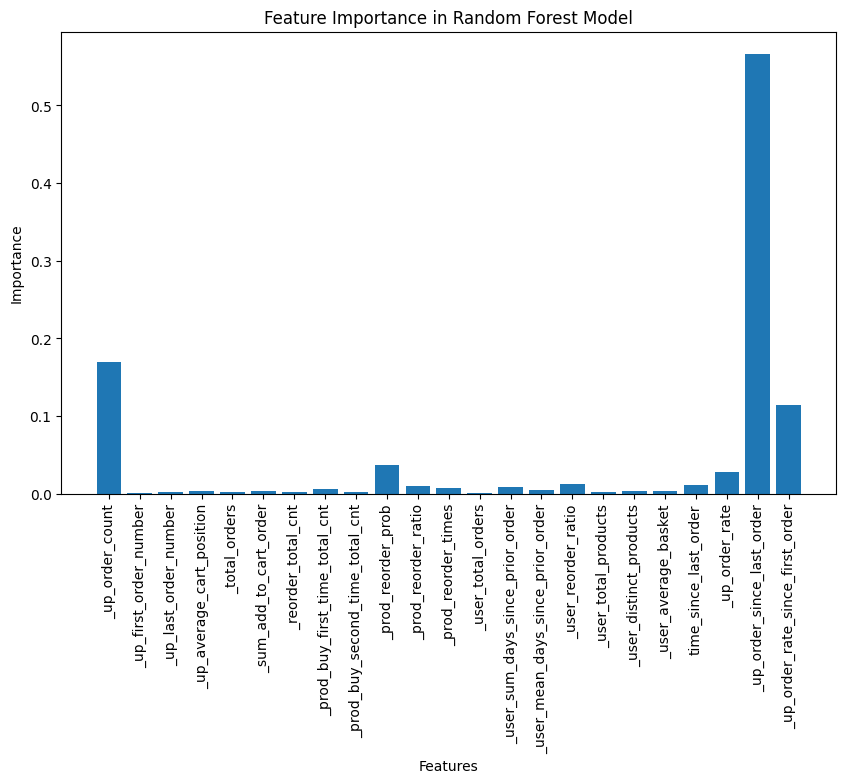

In [122]:
# Split the data into train and test sets
train = data.loc[data.eval_set == "train", :]
train.drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis=1, inplace=True)
train.loc[:, 'reordered'] = train.reordered.fillna(0)

X_test = data.loc[data.eval_set == "test", :]

# Subsample the data to save time during training
X_train, X_val, y_train, y_val = train_test_split(train.drop('reordered', axis=1), train.reordered,
                                                    test_size=0.9, random_state=42)

# Create a Random Forest model instance
rf_model = RandomForestClassifier(n_jobs=16, random_state=42)

# Fit the model using the training data
rf_model.fit(X_train, y_train)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(X_train.columns, feature_importances)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance in Random Forest Model")
plt.show()




In [148]:
# Make predictions on the test data
X_test.loc[:, 'reordered'] = rf_model.predict(X_test.drop(['eval_set', 'user_id', 'order_id', 'reordered', 'product_id'], axis=1))

# Keep the same post-processing steps as before
X_test.loc[:, 'product_id'] = X_test.product_id.astype(str)

submit = ka_add_groupby_features_n_vs_1(X_test[X_test.reordered == 1], 
                                        group_columns_list=['order_id'],
                                        target_columns_list=['product_id'],
                                        methods_list=[lambda x: ' '.join(set(x))], keep_only_stats=True)
submit.columns = sample_submission.columns.tolist()

submit_final_rf = sample_submission[['order_id']].merge(submit, how='left').fillna('None')
submit_final_rf

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


add stats features begin ......
add stats features end ......
time lapsing 0.3114814758300781 s 



,order_id,products
0,17,13107
1,34,16083
2,137,None
3,182,9337 13629 39275
4,257,49235
...,...,...
74995,3420740,None
74996,3420877,21137 13176 13646
74997,3420888,35951 44632
74998,3420989,47766


In [149]:
y_val_pred = rf_model.predict(X_val)
f1 = f1_score(y_val, y_val_pred)
accuracy = accuracy_score(y_val, y_val_pred)

print("F1 Score: {:.4f}".format(f1))
print("Accuracy Score: {:.4f}".format(accuracy))

F1 Score: 0.2693
Accuracy Score: 0.9085


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


## NN MLP

In [130]:
# Count the number of rows for each value of the target column
counts = train['reordered'].value_counts()

# Find the minimum count between the two values
min_count = min(counts.values)
print(counts.values)
print(min_count)

# Split the dataframe into two based on the target column
df_0 = train[train['reordered'] == 0]
df_1 = train[train['reordered'] == 1]

# Resample both dataframes to have the minimum count
df_0_resampled = df_0.sample(n=min_count, replace=False)
df_1_resampled = df_1.sample(n=min_count, replace=False)

# Concatenate the resampled dataframes into a balanced dataframe
balanced_df = pd.concat([df_0_resampled, df_1_resampled])

# Shuffle the rows in the balanced dataframe
balanced_df = balanced_df.sample(frac=1, random_state=42)
print(balanced_df.shape)

# subsample 
X_train, X_val, y_train, y_val = train_test_split(balanced_df.drop('reordered', axis=1), balanced_df.reordered,
                                                    test_size=0.8, random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.98, random_state=42)

# x_test_nn = X_test.drop(['eval_set', 'user_id', 'order_id', 'reordered', 'product_id'], axis=1)
# y_test_nn = X_test.reordered

[7645837  828824]
828824
(1657648, 24)


In [133]:
model = MLPClassifier(solver='adam',
                      activation ='relu',
                      learning_rate_init = 0.0000001,
                      alpha=1e-5,
                      hidden_layer_sizes=(128, 32, 16),
                      random_state=1,
                      warm_start=True,
                      batch_size = 4096, 
                      verbose = True, 
                      tol=1e-10,
                      early_stopping=True)

model.fit(X_train.values, y_train.values)

Iteration 1, loss = 16.17452342
Validation score: 0.504600
Iteration 2, loss = 16.15226950
Validation score: 0.504992
Iteration 3, loss = 16.12986086
Validation score: 0.505354
Iteration 4, loss = 16.10750189
Validation score: 0.505625
Iteration 5, loss = 16.08444099
Validation score: 0.505867
Iteration 6, loss = 16.06109046
Validation score: 0.506229
Iteration 7, loss = 16.03719944
Validation score: 0.506922
Iteration 8, loss = 16.01325712
Validation score: 0.507465
Iteration 9, loss = 15.98875187
Validation score: 0.508099
Iteration 10, loss = 15.96355906
Validation score: 0.508581
Iteration 11, loss = 15.93801142
Validation score: 0.508642
Iteration 12, loss = 15.91199438
Validation score: 0.509245
Iteration 13, loss = 15.88485034
Validation score: 0.510029
Iteration 14, loss = 15.85711901
Validation score: 0.510331
Iteration 15, loss = 15.82887767
Validation score: 0.510844
Iteration 16, loss = 15.80058688
Validation score: 0.511658
Iteration 17, loss = 15.77134517
Validation score

MLPClassifier(alpha=1e-05, batch_size=4096, early_stopping=True,
              hidden_layer_sizes=(128, 32, 16), learning_rate_init=1e-07,
              random_state=1, tol=1e-10, verbose=True, warm_start=True)

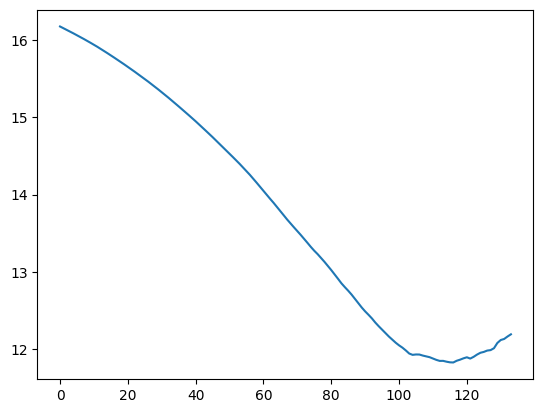

In [134]:
plt.plot(model.loss_curve_)

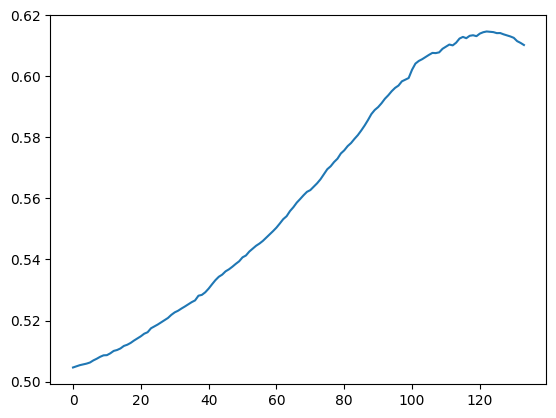

In [135]:
plt.plot(model.validation_scores_)

# 6.Ensemble Method

## Voting

In [35]:

#train test split
train = data.loc[data.eval_set == "train", :]
train.drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis=1, inplace=True)
train.loc[:, 'reordered'] = train.reordered.fillna(0)

X_test = data.loc[data.eval_set == "test", :]

# subsample save time
X_train, X_val, y_train, y_val = train_test_split(train.drop('reordered', axis=1), train.reordered,
                                                    test_size=0.9, random_state=42)

### Hard

In [128]:
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
    ,"n_jobs"           : 16
}

# Create an XGBoost model
xgb_model = xgboost.XGBClassifier(**xgb_params)

# Create a Decision Tree model
dt_model = DecisionTreeClassifier(max_depth=10, min_samples_split=10, min_samples_leaf=10,class_weight='balanced')

# Create a Logistic Regression model
lr_model = LogisticRegression(n_jobs=16, random_state=42,class_weight='balanced')

# Create a Voting Classifier instance, including all models
voting_classifier = VotingClassifier(estimators=[
    ('xgb', xgb_model),
    ('dt', dt_model),
    ('lr', lr_model)
], voting='hard')

# Fit the model using the training data
voting_classifier.fit(X_train, y_train)

# Make predictions on the test data
X_test.loc[:, 'reordered'] = voting_classifier.predict(X_test.drop(['eval_set', 'user_id', 'order_id', 'reordered', 'product_id'], axis=1))

# Keep the same post-processing steps as before
X_test.loc[:, 'product_id'] = X_test.product_id.astype(str)

submit = ka_add_groupby_features_n_vs_1(X_test[X_test.reordered == 1], 
                                        group_columns_list=['order_id'],
                                        target_columns_list=['product_id'],
                                        methods_list=[lambda x: ' '.join(set(x))], keep_only_stats=True)
submit.columns = sample_submission.columns.tolist()

submit_final_hard = sample_submission[['order_id']].merge(submit, how='left').fillna('None')
submit_final_hard

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


add stats features begin ......
add stats features end ......
time lapsing 0.6443753242492676 s 



,order_id,products
0,17,38777 21903 39928 39275
1,34,21137 13176 47766 42265 44632
2,137,26209 24184 18465 41787 21903 43352 27104 3412...
3,182,39275 22935 9337 47209 5479 8518
4,257,21137 12341 27966 49235 37646 22035 27104 4605...
...,...,...
74995,3420740,19660 48679 8174 39928 35951
74996,3420877,21137 27966 21903 13176 26604 8277 47209 40706...
74997,3420888,8193 8424 42736 43961 44632 31506 22935 35951 ...
74998,3420989,27521 7781 46676 17948 21616 8277 35951 47766 ...


### Soft

In [129]:
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
    ,"n_jobs"           : 16
}

# Create an XGBoost model
xgb_model = xgboost.XGBClassifier(**xgb_params)

# Create a Decision Tree model
dt_model = DecisionTreeClassifier(max_depth=10, min_samples_split=10, min_samples_leaf=10,class_weight='balanced')

# Create a Logistic Regression model
lr_model = LogisticRegression(n_jobs=16, random_state=42,class_weight='balanced')

# Create a Voting Classifier instance, including all models
voting_classifier = VotingClassifier(estimators=[
    ('xgb', xgb_model),
    ('dt', dt_model),
    ('lr', lr_model)
], voting='soft')

# Fit the model using the training data
voting_classifier.fit(X_train, y_train)

# Make predictions on the test data
X_test.loc[:, 'reordered'] = voting_classifier.predict(X_test.drop(['eval_set', 'user_id', 'order_id', 'reordered', 'product_id'], axis=1))

# Keep the same post-processing steps as before
X_test.loc[:, 'product_id'] = X_test.product_id.astype(str)

submit = ka_add_groupby_features_n_vs_1(X_test[X_test.reordered == 1], 
                                        group_columns_list=['order_id'],
                                        target_columns_list=['product_id'],
                                        methods_list=[lambda x: ' '.join(set(x))], keep_only_stats=True)
submit.columns = sample_submission.columns.tolist()

submit_final_soft = sample_submission[['order_id']].merge(submit, how='left').fillna('None')
submit_final_soft

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


add stats features begin ......
add stats features end ......
time lapsing 0.6992275714874268 s 



,order_id,products
0,17,21903 13107 21463 39275
1,34,21137 13176 47766 16083 2596 39475
2,137,38689 5134 41787 21903 23794 2326 25890 24852
3,182,33000 47672 39275 9337 11520 47209 5479 13629
4,257,21137 27966 49235 29837 37646 27104 4605 45013...
...,...,...
74995,3420740,19660 49005 39928 35951 39146
74996,3420877,21137 27966 43122 21903 13176 49111 12238 8277...
74997,3420888,43961 44632 22935 7963 35951 46906 47766 28985...
74998,3420989,46676 21616 42450 35004 43210 47766 13517


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
